# Random Forest Regression Model 1 (RFR1)
Without reservoir dynamics

## Data Processing

In [1]:
import sys
import geemap
import ee
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from pathlib import Path
import time
from random import randint
import json


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# import tensorflow as tf
import HydroErr as he
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
proj_dir = Path("../../..")
model_name = "RFR1"

In [3]:
utils = str(proj_dir / 'utils')
sys.path.insert(0, utils)
from sql import connect # utility functions for connecting to MySQL

In [4]:
# Create a connection object to the MySQL database
# conn = connect.Connect(str(proj_dir / "Methods/2.Data/DBManagement/mysql_config.ini"))
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
connection = conn.conn

Connecting to MySQL database...
Connection established.


In [5]:
reaches_and_dams = pd.read_csv(proj_dir / "Methods/machine_learning/ML2/reaches_and_dams.csv")

In [6]:
reaches_of_interest = ["Columbia_River_59","Willamette_River_15", "Kootenay_River_47", "Okanogan_River_29"]
# also test for Willamette_River_16, Kootenay_River_47, 

In [7]:
# query = f"""
# SELECT 
#     STR_TO_DATE(CONCAT(Year,
#                     '-',
#                     LPAD(Month, 2, '00'),
#                     '-',
#                     LPAD(DayOfMonth, 2, '00')),
#             '%Y-%m-%d') AS Date,
#     Month,
#     DayOfMonth,
#     ROUND(WaterTemp, 2) as WaterTemp,
#     ROUND(LandTemp, 2) as LandTemp,
#     ROUND(NDVI, 2) as NDVI,
#     ClimateClass,
#     --     ROUND(((watertemp - WaterTemperature) / WaterTemperature),
#     --             2) AS PercentDeviation,
#     --     ROUND((watertemp - WaterTemperature), 2) AS Deviation,
#     Width,
#     ReachID,
#     ReachName,
#     ROUND(InsituTemp, 2) AS InsituTemp
# FROM
#     (SELECT 
#         IF(DAY(ReachLandsatWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachLandsatWaterTemp.date) AS Month,
#             YEAR(ReachLandsatWaterTemp.date) AS Year,
#             AVG(ReachLandsatWaterTemp.Value) AS WaterTemp,
#             AVG(ReachLandsatLandTemp.Value) AS LandTemp,
#             AVG(ReachNDVI.Value) AS NDVI,
#             IFNULL(Reaches.WidthMean, 30) AS Width,
#             Reaches.ClimateClass AS ClimateClass,
#             ReachLandsatWaterTemp.ReachID AS ReachID,
#             Reaches.Name AS ReachName
#     FROM
#         ReachLandsatWaterTemp
#     INNER JOIN ReachLandsatLandTemp USING (date , ReachID)
#     INNER JOIN ReachNDVI USING (date , ReachID)
#     INNER JOIN Reaches USING (ReachID)
#     -- WHERE
#     --    Reaches.Name NOT IN {tuple(reaches_of_interest)}
#     --        AND ReachLandsatWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ClimateClass , ReachID , Width) AS T
#     --         INNER JOIN
#     --     ReachLandsatLTMSemiMonthly USING (DayOfMonth , Month , ReachID)
#         LEFT JOIN
#     (SELECT 
#         IF(DAY(ReachInsituWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachInsituWaterTemp.date) AS Month,
#             YEAR(ReachInsituWaterTemp.date) AS Year,
#             AVG(ReachInsituWaterTemp.Value) AS InsituTemp,
#             ReachInsituWaterTemp.ReachID AS ReachID
#     FROM
#         ReachInsituWaterTemp
#     INNER JOIN Reaches USING (ReachID)
#     WHERE
#         ReachInsituWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ReachID) AS I USING (DayOfMonth , Month , Year , ReachID)
# -- ORDER BY RAND();
# """ 
# # print(query)

# df = conn.query_with_fetchmany(query, chunksize=100)

# df.to_csv(proj_dir / "Methods/2.Data/ML_input_data.csv", index=False)

df = pd.read_csv(proj_dir / "Methods/2.Data/ML_input_data.csv")

In [8]:
# df = pd.concat([chunk for chunk in data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear

dels = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_dels.csv")
dels["Date"] = pd.to_datetime(dels["Date"])
sarea = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_sarea.csv")
sarea["Date"] = pd.to_datetime(sarea["Date"])

In [9]:
df = df.merge(reaches_and_dams, on="ReachName", how="left")
df = df.merge(dels, on=["GranD_ID", "Date"], how="left")
df = df.merge(sarea, on=["GranD_ID", "Date"], how="left")

df.rename(columns={"dS (m3)": "dels", "area (km2)": "sarea", "Within_n*10km": "rel_dist"}, inplace=True)

original_cols = df.columns
# df.head()

In [10]:
# plot kde of dels
# df[abs(df["dels"])>0]["dels"].plot.kde()
# df["sarea"].plot.kde()
# df["sarea_scaled"].plot.kde()

In [11]:
# Scalers
# load scalers and model
with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "rb") as f:
    scalers = pickle.load(f)

    dayofmonth_scaler = scalers["dayofmonth_scaler"]
    month_scaler = scalers["month_scaler"]
    watertemp_scaler =  scalers["watertemp_scaler"]
    landtemp_scaler = scalers["landtemp_scaler"]
    width_scaler = scalers["width_scaler"]
    NDVI_scaler = scalers["NDVI_scaler"]
    climate_scaler = scalers["climate_scaler"]
    dels_scaler =   scalers["dels_scaler"]
    sarea_scaler = scalers["sarea_scaler"]
    rel_dist_scaler = scalers["rel_dist_scaler"]

# # define scalers
# dayofmonth_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'DayOfMonth': range(1, 15+1)}))
# month_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'Month': range(1, 12+1)}))
# watertemp_scaler = StandardScaler().fit(df[['WaterTemp']])
# landtemp_scaler = StandardScaler().fit(df[['LandTemp']])
# # watertemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['WaterTemp']])
# # landtemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['LandTemp']])
# width_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['Width']])
# NDVI_scaler = StandardScaler().fit(df[['NDVI']])
# # NDVI_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df3[['NDVI']])
# climate_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'ClimateClass': range(1, 30+1)}))
# dels_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['dels']])
# sarea_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['sarea']])
# rel_dist_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'rel_dist': range(0, 5+1)}))

# replace missing values for dels, sarea, and rel_dist with the 0
df["dels"].fillna(0, inplace=True)
df["sarea"].fillna(0, inplace=True)
df["rel_dist"].fillna(0, inplace=True)

# Scale values
df["DayOfMonth_scaled"] = dayofmonth_scaler.transform(df[["DayOfMonth"]])
df["Month_scaled"] = month_scaler.transform(df[["Month"]])
df["LandTemp_scaled"] = landtemp_scaler.transform(df[["LandTemp"]])
df["WaterTemp_scaled"] = watertemp_scaler.transform(df[["WaterTemp"]])
df["Width_scaled"] = width_scaler.transform(df[["Width"]])
df["NDVI_scaled"] = NDVI_scaler.transform(df[["NDVI"]])
df["ClimateClass_scaled"] = climate_scaler.transform(df[["ClimateClass"]])
df["dels_scaled"] = dels_scaler.transform(df[["dels"]])
df["sarea_scaled"] = sarea_scaler.transform(df[["sarea"]])
df["rel_dist_scaled"] = rel_dist_scaler.transform(df[["rel_dist"]])

# # save the scalers
# with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "wb") as f:
#     pickle.dump({
#         "dayofmonth_scaler": dayofmonth_scaler,
#         "month_scaler": month_scaler,
#         "watertemp_scaler": watertemp_scaler,
#         "landtemp_scaler": landtemp_scaler,
#         "width_scaler": width_scaler,
#         "NDVI_scaler": NDVI_scaler,
#         "climate_scaler": climate_scaler,
#         "dels_scaler": dels_scaler,
#         "sarea_scaler": sarea_scaler,
#         "rel_dist_scaler": rel_dist_scaler,
#     }, f)

In [12]:
# df.head()

In [13]:
# df.columns

In [13]:
handpicked = df[(df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())].copy()

# X and y to be used for model (excluding handpicked reaches of interest)
X = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())][
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())]["InsituTemp"]
X_rel_dist = df[
    (~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())
][
    [
        "rel_dist",
    ]
]

# dev set and test set (including handpicked reaches of interest)
dev_set, test_set = train_test_split(df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())], test_size=0.1, random_state=1993)
test_set = pd.concat([test_set, handpicked])

X_dev = dev_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_dev = dev_set["InsituTemp"]

X_test = test_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_test = test_set["InsituTemp"]

# X and y for handpicked reaches of interest
X_handpicked = handpicked[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_handpicked = handpicked["InsituTemp"]


## Model Development

In [18]:
model_name = "RFR1"

cv_splitter = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1993)
param_space = {
    "n_estimators": [10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 1000],
    # "n_estimators": [10, 11],
    # "max_depth": [None],
    # "min_samples_split": [2, 5],
    # "max_features": ["auto", "sqrt", "log2"],
    # "random_state": [1993],
}

model = RandomForestRegressor(random_state=1993)
search = GridSearchCV(model, param_space, cv=cv_splitter, scoring="neg_mean_squared_error")
search.fit(X, y)
# model.fit(X, y)
# print(model.alpha_)
# print(model.intercept_)
# print(LR1.predict([[0, 0]]))

Text(0.5, 1.0, 'GridSearchCV Results')

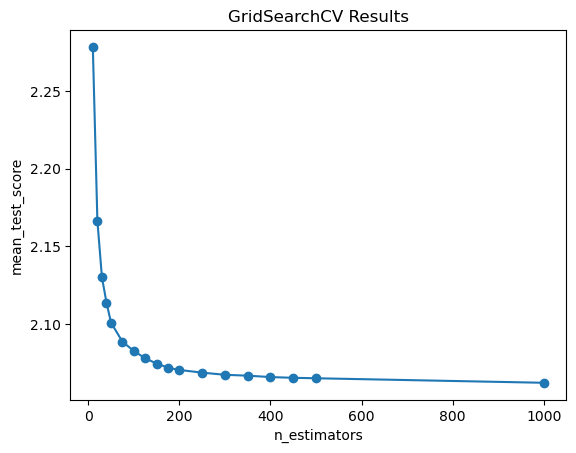

In [16]:
param_n_estimators = search.cv_results_["param_n_estimators"].tolist()
mean_test_score = (-search.cv_results_["mean_test_score"]).tolist()

cv_results = pd.DataFrame(
    {
        "param_n_estimators": param_n_estimators,
        "mean_test_score": mean_test_score,
    }
)

fig, ax = plt.subplots()
# ax.scatter(param_n_estimators, mean_test_score)
ax.plot(param_n_estimators, mean_test_score, marker="o")
ax.set_xlabel("n_estimators")
ax.set_ylabel("mean_test_score")
ax.set_title("GridSearchCV Results")

In [18]:
cv_results["delta"] = round(cv_results["mean_test_score"].diff(), 3)
cv_results.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_cv_results.csv", index=False)

In [19]:
model_dev_mse = pd.DataFrame(columns=list(search.cv_results_["params"][0].keys()) + ["mse", "fold"])

n_folds = search.n_splits_
n_param_combinations = len(search.cv_results_["params"])


for j in range(n_param_combinations):
    for i in range(n_folds):
        model_dev_mse = pd.concat(
            [
                model_dev_mse,
                pd.DataFrame(
                    [
                        {
                            **search.cv_results_["params"][j],
                            "mse": search.cv_results_["split" + str(i) + "_test_score"][j],
                            "fold": i,
                        }
                    ]
                ),
            ]
        )

model_dev_mse["mse"] = -model_dev_mse["mse"]
model_dev_mse.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_dev_mse.csv", index=False)

In [20]:
# manually choose the best set of hyperparameters based on the plot
selected_n_estimators = 150
# selected_combination = search.best_params_
selected_combination = search.cv_results_["params"][param_n_estimators.index(selected_n_estimators)]

In [21]:
# save the hyperparameters
hyperparameters = pd.DataFrame(
    {
        "hyperparameter": list(selected_combination.keys()),
        "value": list(selected_combination.values()),
    }
)
hyperparameters.model = model_name

hyperparameters.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_hyperparameters.csv", index=False)

## Model Evaluation (Using cross-validation)

In [22]:
# model_eval = pd.DataFrame(columns=["model", "fold", "rmse", "nse", "r_sqaured", "mse"])

# model_final = search.best_estimator_

# for i, (train_index, test_index) in enumerate(cv_splitter.split(X)):
#     X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
#     y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]
#     model_final.fit(X_train_, y_train_)
#     y_pred = model_final.predict(X_test_)
#     rmse = he.rmse(simulated_array=list(y_pred), observed_array=list(y_test_))
#     nse = he.nse(simulated_array=list(y_pred), observed_array=list(y_test_))
#     r_squared = he.r_squared(simulated_array=list(y_pred), observed_array=list(y_test_))
#     mse = he.mse(simulated_array=list(y_pred), observed_array=list(y_test_))
#     model_eval = pd.concat([model_eval, pd.DataFrame([[f"{model_name}", i, rmse, nse, r_squared, mse]], columns=["model", "fold", "rmse", "nse", "r_sqaured", "mse"])], ignore_index=True)


In [17]:
model_eval = pd.DataFrame(
    columns=[
        "model",
        "fold",
        "rmse",
        "nse",
        "r_sqaured",
        "rmse_within_50",
        "nse_within_50",
        "r_sqaured_within_50",
        "rmse_beyond_50",
        "nse_beyond_50",
        "r_sqaured_beyond_50",
        "mse_beyond_50",
    ]
)
# model_final = search.best_estimator_
# model_final = RandomForestRegressor(**selected_combination, random_state=1993)
model_final = RandomForestRegressor(n_estimators=1000, random_state=1993)

cv_splitter = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1993)

for i, (train_index, test_index) in enumerate(cv_splitter.split(X)):
    X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]

    X_test_within_50 = X.iloc[test_index][X_rel_dist.iloc[test_index]["rel_dist"] != 0]
    y_test_within_50 = y.iloc[test_index][X_rel_dist.iloc[test_index]["rel_dist"] != 0]

    X_test_beyond_50 = X.iloc[test_index][X_rel_dist.iloc[test_index]["rel_dist"] == 0]
    y_test_beyond_50 = y.iloc[test_index][X_rel_dist.iloc[test_index]["rel_dist"] == 0]

    model_final.fit(X_train_, y_train_)
    y_pred = model_final.predict(X_test_)
    y_pred_within_50 = model_final.predict(X_test_within_50)
    y_pred_beyond_50 = model_final.predict(X_test_beyond_50)

    rmse = he.rmse(simulated_array=list(y_pred.squeeze()), observed_array=list(y_test_))
    nse = he.nse(simulated_array=list(y_pred.squeeze()), observed_array=list(y_test_))
    r_squared = he.r_squared(
        simulated_array=list(y_pred.squeeze()), observed_array=list(y_test_)
    )
    mse = he.mse(simulated_array=list(y_pred.squeeze()), observed_array=list(y_test_))

    rmse_within_50 = he.rmse(
        simulated_array=list(y_pred_within_50.squeeze()),
        observed_array=list(y_test_within_50),
    )
    nse_within_50 = he.nse(
        simulated_array=list(y_pred_within_50.squeeze()),
        observed_array=list(y_test_within_50),
    )
    r_squared_within_50 = he.r_squared(
        simulated_array=list(y_pred_within_50.squeeze()),
        observed_array=list(y_test_within_50),
    )
    mse_within_50 = he.mse(
        simulated_array=list(y_pred_within_50.squeeze()),
        observed_array=list(y_test_within_50),
    )

    rmse_beyond_50 = he.rmse(
        simulated_array=list(y_pred_beyond_50.squeeze()),
        observed_array=list(y_test_beyond_50),
    )
    nse_beyond_50 = he.nse(
        simulated_array=list(y_pred_beyond_50.squeeze()),
        observed_array=list(y_test_beyond_50),
    )
    r_squared_beyond_50 = he.r_squared(
        simulated_array=list(y_pred_beyond_50.squeeze()),
        observed_array=list(y_test_beyond_50),
    )
    mse_beyond_50 = he.mse(
        simulated_array=list(y_pred_beyond_50.squeeze()),
        observed_array=list(y_test_beyond_50),
    )

    model_eval = pd.concat(
        [
            model_eval,
            pd.DataFrame(
                [
                    [
                        f"{model_name}",
                        i,
                        rmse,
                        nse,
                        r_squared,
                        mse,
                        rmse_within_50,
                        nse_within_50,
                        r_squared_within_50,
                        mse_within_50,
                        rmse_beyond_50,
                        nse_beyond_50,
                        r_squared_beyond_50,
                        mse_beyond_50,
                    ]
                ],
                columns=[
                    "model",
                    "fold",
                    "rmse",
                    "nse",
                    "r_sqaured",
                    "mse",
                    "rmse_within_50",
                    "nse_within_50",
                    "r_sqaured_within_50",
                    "mse_within_50",
                    "rmse_beyond_50",
                    "nse_beyond_50",
                    "r_sqaured_beyond_50",
                    "mse_beyond_50",
                ],
            ),
        ],
        ignore_index=True,
    )

In [23]:
# model_eval

,model,fold,rmse,nse,r_sqaured,rmse_within_50,nse_within_50,r_sqaured_within_50,rmse_beyond_50,nse_beyond_50,r_sqaured_beyond_50,mse_beyond_50,mse,mse_within_50
0,RFR1,0,1.420834,0.941151,0.941181,1.326822,0.952721,0.953587,1.433531,0.938870,0.938884,2.055013,2.018769,1.760457
1,RFR1,1,1.455692,0.941795,0.941874,1.480521,0.942040,0.942416,1.451724,0.941264,0.941316,2.107502,2.119040,2.191942
2,RFR1,2,1.424625,0.943359,0.943385,1.432387,0.946770,0.947485,1.423524,0.942284,0.942368,2.026422,2.029555,2.051732
3,RFR1,3,1.535192,0.936213,0.936366,1.479969,0.943596,0.943680,1.544859,0.934669,0.934916,2.386590,2.356814,2.190309
4,RFR1,4,1.418419,0.944225,0.944359,1.303175,0.952545,0.955347,1.437952,0.942186,0.942368,2.067707,2.011914,1.698264
5,RFR1,5,1.406113,0.943120,0.943230,1.306408,0.954784,0.956054,1.421600,0.940460,0.940528,2.020946,1.977153,1.706702
6,RFR1,6,1.474863,0.940951,0.941025,1.411268,0.951686,0.952329,1.483569,0.939013,0.939136,2.200976,2.175222,1.991676
7,RFR1,7,1.439900,0.943811,0.943848,1.427195,0.945712,0.946930,1.442101,0.943214,0.943381,2.079654,2.073312,2.036886
8,RFR1,8,1.357108,0.948489,0.948491,1.444610,0.944562,0.944647,1.343879,0.948742,0.948750,1.806011,1.841743,2.086897
9,RFR1,9,1.442941,0.941038,0.941100,1.344326,0.948168,0.949221,1.459431,0.939056,0.939110,2.129939,2.082078,1.807211


Text(0.5, 1.0, 'Boxplot of RMSE')

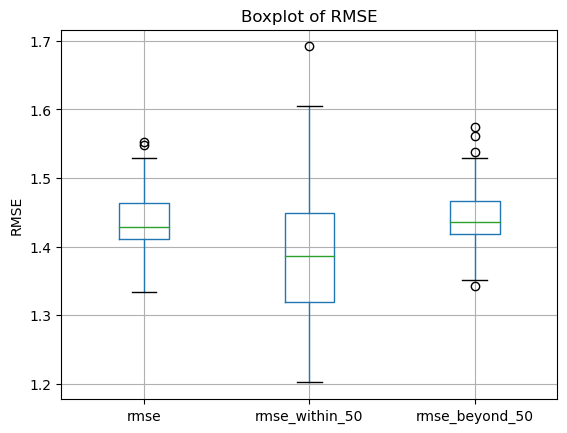

In [18]:
# boxplot of model evaluation metrics
fig, ax = plt.subplots()
model_eval.boxplot(
    column=[
        "rmse",
        "rmse_within_50",
        "rmse_beyond_50",
    ],
    ax=ax,
)
ax.set_ylabel("RMSE")
ax.set_title("Boxplot of RMSE")


In [31]:
model_eval.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_eval.csv", index=False)

## Testing (Train with dev set and test with test set)

In [24]:
model_final.fit(X_dev, y_dev)
y_pred = model_final.predict(X_test)
rmse = he.rmse(simulated_array=list(y_pred), observed_array=list(y_test))
nse = he.nse(simulated_array=list(y_pred), observed_array=list(y_test))
r_squared = he.r_squared(simulated_array=list(y_pred), observed_array=list(y_test))
mse = he.mse(simulated_array=list(y_pred), observed_array=list(y_test))

model_test = pd.DataFrame([[f"{model_name}", rmse, nse, r_squared, mse]], columns=["model", "rmse", "nse", "r_sqaured", "mse"])
model_test.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_test.csv", index=False)




In [25]:
test_set[f"{model_name}"] = y_pred
test_set.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_test_set.csv", index=False)

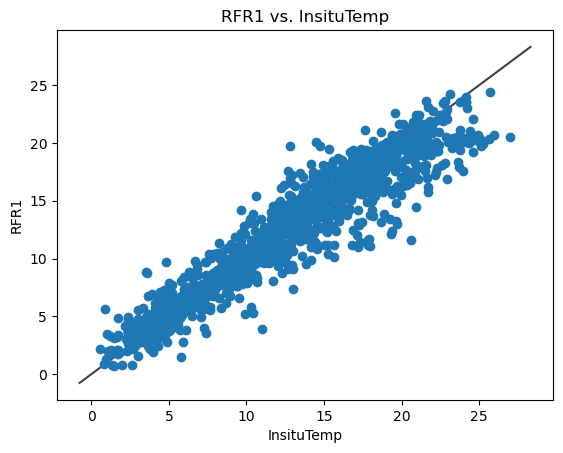

In [26]:
# plot the test model vs. insitu
fig, ax = plt.subplots()
ax.scatter(test_set["InsituTemp"], test_set[f"{model_name}"])
ax.set_xlabel("InsituTemp")
ax.set_ylabel(f"{model_name}")
ax.set_title(f"{model_name} vs. InsituTemp")

# add 1:1 line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)


# Finally, train the model with the complete dataset and store it

In [27]:
# X and y to be used for final model (excluding handpicked reaches of interest)
X_final = df[
    (~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())
][
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_final = df[
    (~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())
]["InsituTemp"]

model_final.fit(X_final, y_final)

# # save the coefficients
# coefficients = pd.DataFrame(
#     {
#         "variable": X_final.columns.to_list() + ["intercept"],
#         "coefficient": model_final.coef_.tolist() + [model_final.intercept_],
#     }
# )
# coefficients["model"] = model_name

# coefficients.to_csv(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_coefficients.csv", index=False)

RandomForestRegressor(n_estimators=1000, random_state=1993)

In [28]:
# save the model
with open(proj_dir / f"Results/2.WaterTempEst/2.RandomForestRegression/{model_name}_final_model.pkl", "wb") as f:
    pickle.dump(model_final, f)